In [4]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import pathlib
from PIL import Image
from Crypto.Cipher import DES3, AES
from Crypto.Util.Padding import pad, unpad
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout

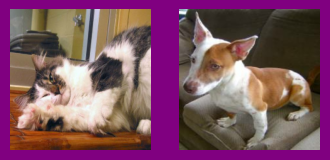

In [33]:
def preprocessing(filename,size=224):
    image = tf.io.read_file(filename)
    decode = tf.image.decode_image(image)
    resize = tf.image.resize(decode,size=[size,size])
    rescale = resize/255.
    return rescale
image_cat = preprocessing("test_set/test_data/cats/cat.4059.jpg")
image_dog = preprocessing("test_set/test_data/dogs/dog.4054.jpg")
plt.figure(figsize=(4,3),facecolor="purple")
plt.subplot(121)
plt.imshow(image_cat)
plt.axis(False)
plt.subplot(122)
plt.imshow(image_dog)
plt.axis(False)
plt.show()

In [2]:
def preprocess_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = img.convert('RGB') 
    img_array = np.array(img) / 255.0  
    return img_array

def generate_aes_key():
    key = os.urandom(32) 
    return key

def generate_tdes_key():
    key = os.urandom(24) 
    return key

def encrypt_image_aes(image_data, key):
    cipher = AES.new(key, AES.MODE_ECB)
    encrypted_data = cipher.encrypt(pad(image_data.tobytes(), AES.block_size))
    return encrypted_data

def decrypt_image_aes(encrypted_data, key):
    cipher = AES.new(key, AES.MODE_ECB)
    decrypted_data = unpad(cipher.decrypt(encrypted_data), AES.block_size)
    return decrypted_data

def encrypt_image_tdes(image_data, key):
    cipher = DES3.new(key, DES3.MODE_ECB)
    encrypted_data = cipher.encrypt(pad(image_data.tobytes(), DES3.block_size))
    return encrypted_data

def decrypt_image_tdes(encrypted_data, key):
    cipher = DES3.new(key, DES3.MODE_ECB)
    decrypted_data = unpad(cipher.decrypt(encrypted_data), DES3.block_size)
    return decrypted_data
data_dir = 'C:\\Users\\Anmino\\Desktop\\encryption_\\DES\\training_set\\data\\'
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,rotation_range=0.2,
                              width_shift_range=0.2,height_shift_range=0.3,horizontal_flip=True)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,rotation_range=0.2,zoom_range=0.2,horizontal_flip=True,
                             width_shift_range=0.2,height_shift_range=0.3)

train_dir = "training_set/data/"
test_dir = "test_set/test_data/"

train_data = train_gen.flow_from_directory(train_dir,class_mode='binary',
                                           shuffle=True,batch_size=32)
test_data = test_gen.flow_from_directory(test_dir,class_mode='binary',
                                        shuffle=True,batch_size=32)
cat_paths = [os.path.join(data_dir, 'cats', fname) for fname in os.listdir(os.path.join(data_dir, 'cats'))]
dog_paths = [os.path.join(data_dir, 'dogs', fname) for fname in os.listdir(os.path.join(data_dir, 'dogs'))]
original_labels = np.array(['cat', 'dog'])
label_mapping = {'cats': 0, 'dogs': 1}
converted_labels = np.vectorize(label_mapping.get)(class_name)
random.shuffle(cat_paths)
random.shuffle(dog_paths)



aes_key = generate_aes_key()
tdes_key = generate_tdes_key()
encrypted_dataset_aes = []
encrypted_dataset_tdes = []

for image_path in cat_paths:
    image = preprocess_image(image_path)
    encrypted_image_aes = encrypt_image_aes(image, aes_key)
    encrypted_image_tdes = encrypt_image_tdes(image, tdes_key)
    encrypted_dataset_aes.append((encrypted_image_aes, 0)) 
    encrypted_dataset_tdes.append((encrypted_image_tdes, 0))

for image_path in dog_paths:
    image = preprocess_image(image_path)
    encrypted_image_aes = encrypt_image_aes(image, aes_key)
    encrypted_image_tdes = encrypt_image_tdes(image, tdes_key)
    encrypted_dataset_aes.append((encrypted_image_aes, 1)) 
    encrypted_dataset_tdes.append((encrypted_image_tdes, 1))

train_size = int(0.8 * len(encrypted_dataset_aes))
train_dataset_aes = encrypted_dataset_aes[:train_size]
test_dataset_aes = encrypted_dataset_aes[train_size:]
train_dataset_tdes = encrypted_dataset_tdes[:train_size]
test_dataset_tdes = encrypted_dataset_tdes[train_size:]

train_images_aes, train_labels_aes = zip(*train_dataset_aes)
test_images_aes, test_labels_aes = zip(*test_dataset_aes)
train_images_tdes, train_labels_tdes = zip(*train_dataset_tdes)
test_images_tdes, test_labels_tdes = zip(*test_dataset_tdes)

train_images_aes = np.array(train_images_aes)
test_images_aes = np.array(test_images_aes)
train_labels_aes = np.array(train_labels_aes)
test_labels_aes = np.array(test_labels_aes)
train_images_tdes = np.array(train_images_tdes)
test_images_tdes = np.array(test_images_tdes)
train_labels_tdes = np.array(train_labels_tdes)
test_labels_tdes = np.array(test_labels_tdes)

num_images = len(train_images_aes)
image_shape = train_images_aes[0].shape
new_shape = (num_images,) + image_shape

train_images_aes = train_images_aes.reshape(new_shape)
test_images_aes = test_images_aes.reshape(639)
train_images_tdes = train_images_tdes.reshape(new_shape)
test_images_tdes = test_images_tdes.reshape(639)

Found 3194 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [3]:
base_model = keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                            include_top=False,
                                            weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

class callback_data(tf.keras.callbacks.Callback):
    def on_batch_end(self,epochs,logs={}):
        if(logs.get("accuracy")>0.96):
            print("\nTraining Stoping.....")
            self.model.stop_training=True
callback = callback_data()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_data,epochs=150,steps_per_epoch=len(train_data),
         validation_data=test_data,validation_steps=len(test_data),callbacks=[callback])
model.summary()

Epoch 1/150
100/100 [==============================] - 304s 3s/step - loss: 0.2069 - accuracy: 0.9105 - val_loss: 0.1237 - val_accuracy: 0.9491
Epoch 2/150
  1/100 [..............................] - ETA: 4:31 - loss: 0.1365 - accuracy: 0.9375
Training Stoping.....
100/100 [==============================] - 121s 1s/step - loss: 0.0881 - accuracy: 0.9688 - val_loss: 0.1168 - val_accuracy: 0.9535
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']           

                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 33, 33, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 16, 16, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
          

                                                                                                  
 block_7_expand (Conv2D)        (None, 8, 8, 384)    24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 8, 8, 384)   1536        ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
          

 block_10_depthwise_relu (ReLU)  (None, 8, 8, 384)   0           ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 8, 8, 96)     36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)

 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 4, 4, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization

In [5]:
hist = pd.DataFrame(model.history.history)
hist.head()

,loss,accuracy,val_loss,val_accuracy
0,0.206874,0.910457,0.123690,0.949086
1,0.088067,0.968750,0.116815,0.953534


Text(0, 0.5, 'Accuracy')

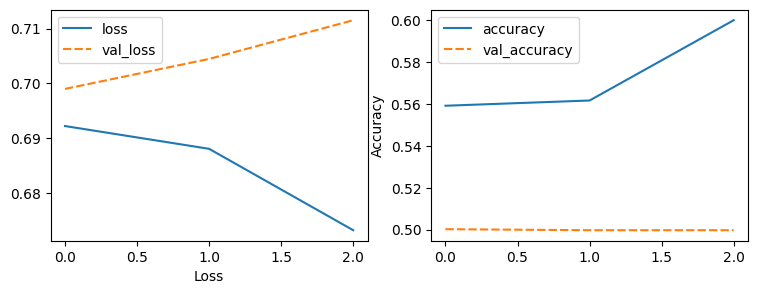

In [24]:
plt.figure(figsize=(9,3))
plt.subplot(121)
sns.lineplot(hist[["loss","val_loss"]])
plt.xlabel("Loss")
plt.subplot(122)
sns.lineplot(hist[["accuracy","val_accuracy"]])
plt.ylabel("Accuracy")

In [26]:
model.evaluate(test_data)

64/64 [==============================] - 108s 2s/step - loss: 0.7115 - accuracy: 0.4998


[0.7115446925163269, 0.49975284934043884]

1/1 [==============================] - 0s 57ms/step


Text(0.5, 1.0, 'Prediction :0')

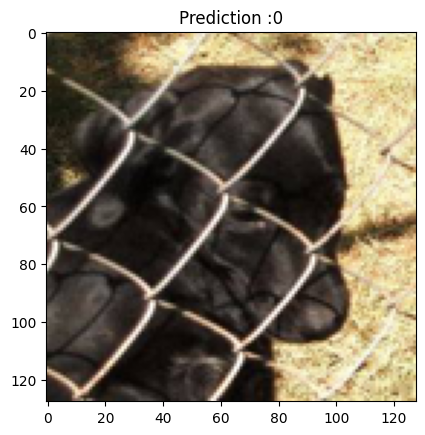

In [28]:
img_ = preprocess_image("test_set/test_data/dogs/dog.4013.jpg")
pred_model = model.predict(tf.expand_dims(img_,axis=0))
pred_class = converted_labels[int(tf.round(pred_model))]
images_,labels_ = test_data.next()
plt.imshow(img_)
plt.title(f"Prediction :{pred_class}")